In [1]:
import numpy as np
from pr3_utils import load_data
from utils import *
from motion import *
from observation import *
from mapping import *
from visual_slam import *
from visualization import *

/Users/liaoweilin/Desktop/ECE276A_PR3/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set parameters
dataset = "10"
reduce_factor = 10
w_scale = 10e-8
v_scale = 200
filename = f"../data/{dataset}.npz"

save_path_traj = f"../fig/trajectory_2d_{dataset}_{reduce_factor}.png"
save_path_mapping = f"../fig/mapping_{dataset}_{reduce_factor}.png"
save_path_slam = f"../fig/slam_{dataset}_{reduce_factor}.png"
save_path_compare = f"../fig/compare_{dataset}_{reduce_factor}.png"

In [3]:
# Load the measurements
t, features, linear_velocity, angular_velocity, K, b, imu_T_cam = load_data(filename)

In [4]:
# transform for further usage
cam_T_imu = inversePose(imu_T_cam)
cam_T_imu[:3,:3] = roll(np.pi) @ cam_T_imu[:3,:3]

In [5]:
# downsample features
selected_feats = np.zeros((4, int(features.shape[1] / reduce_factor) + 1, features.shape[2]))
for i, idx in enumerate(range(0, int(features.shape[1]), reduce_factor)):
    selected_feats[:,i,:] = features[:,idx,:]
print(f"Using {selected_feats.shape[1]} / {features.shape[1]} of features")

Using 1329 / 13289 of features


Start IMU Localization ...


100%|██████████| 3025/3025 [00:00<00:00, 22937.18it/s]


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

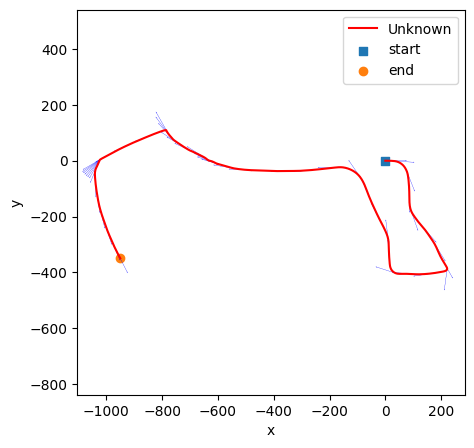

In [6]:
# (a) IMU Localization via EKF Prediction
print("Start IMU Localization ...")
i_T_w, w_T_i = motion_model_prediction(t, linear_velocity, angular_velocity, w_scale)
visualize_trajectory_2d(w_T_i, save_path_traj, show_ori=True)

Start Landmark Mapping ...


100%|██████████| 3026/3026 [32:58<00:00,  1.53it/s]


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

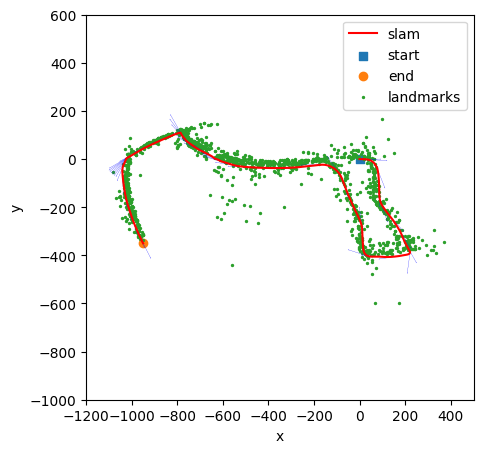

In [7]:
# (b) Landmark Mapping via EKF Update
print("Start Landmark Mapping ...")
landmarks = landmark_mapping(selected_feats, i_T_w, K, b, cam_T_imu, v_scale, w_T_i)
visualize(w_T_i, landmarks, save_path_mapping)

Start Visual-Inertial SLAM ...


 35%|███▍      | 1050/3025 [11:19<20:04,  1.64it/s]/Users/liaoweilin/Desktop/ECE276A_PR3/code/visualization.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(figsize=(5,5))
100%|██████████| 3025/3025 [32:57<00:00,  1.53it/s]


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

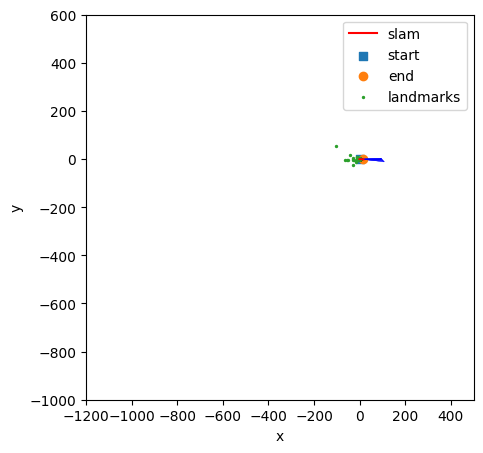

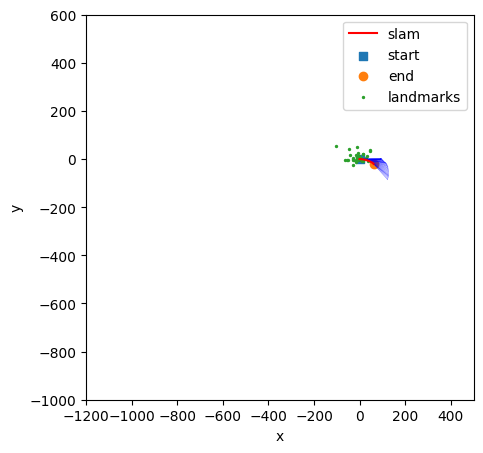

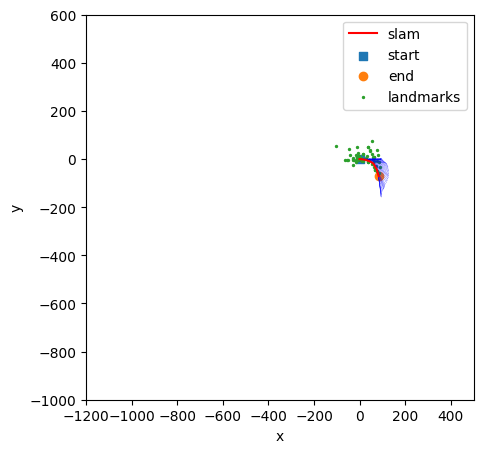

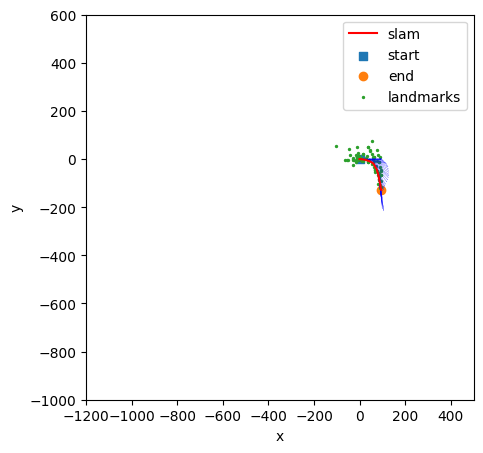

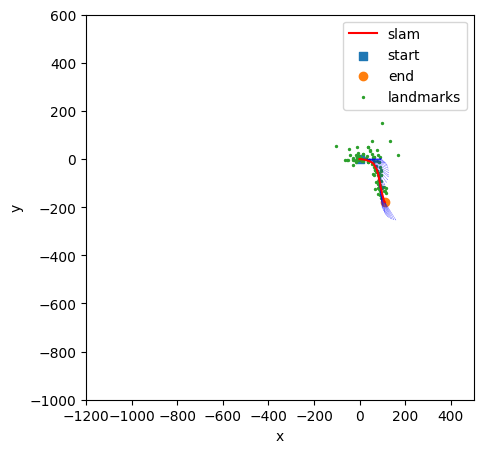

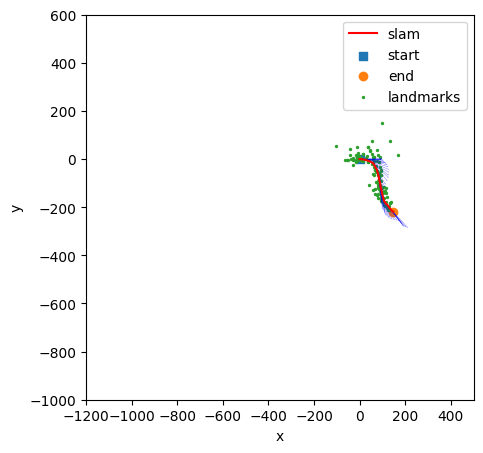

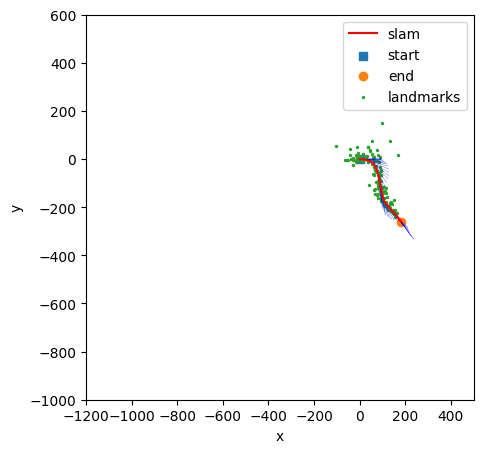

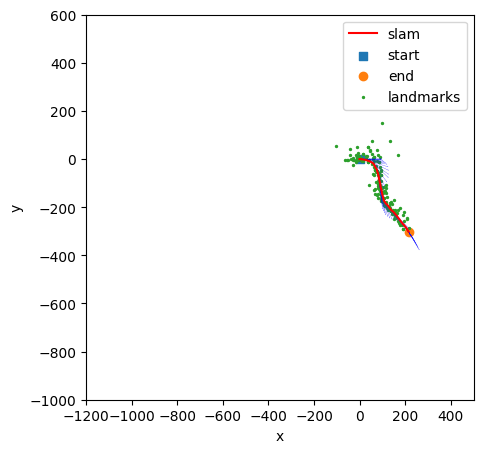

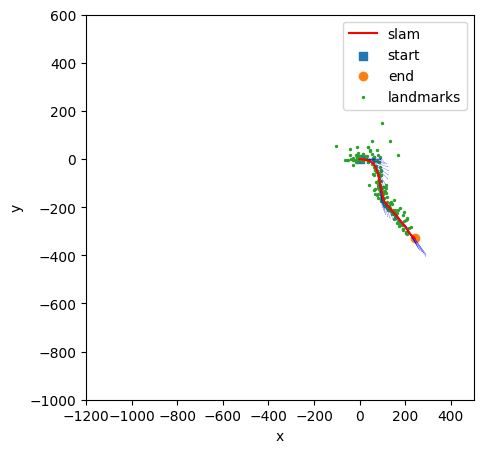

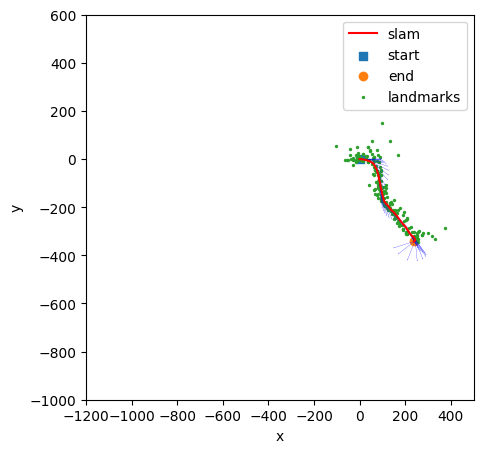

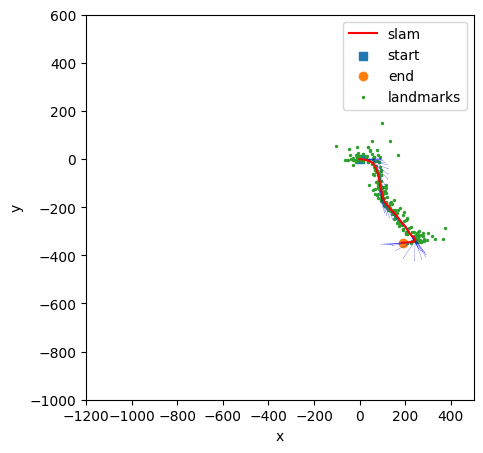

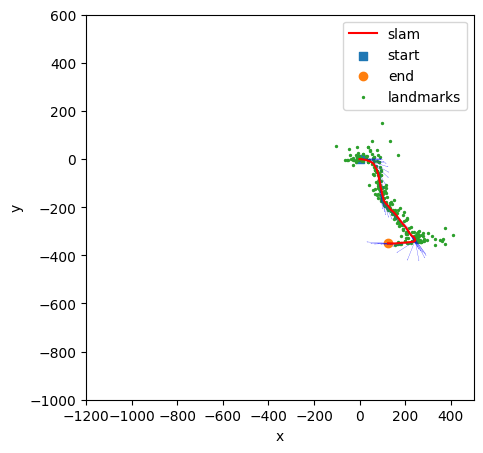

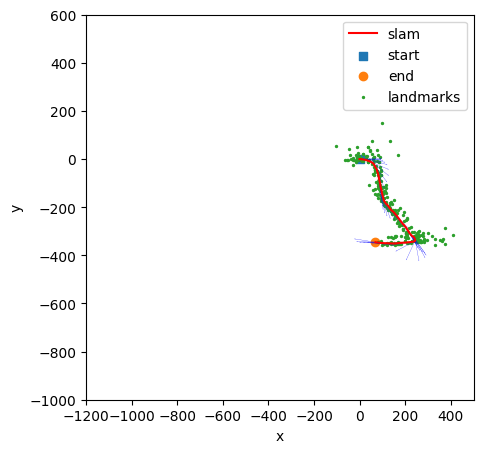

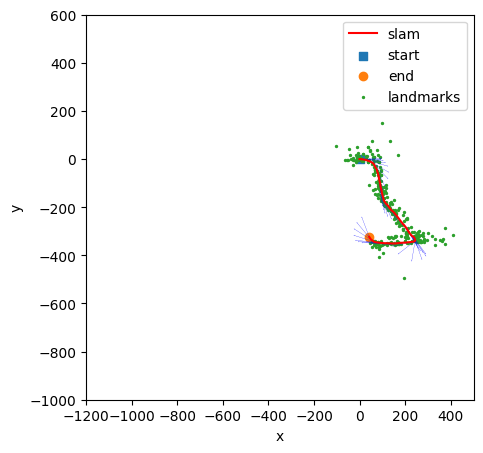

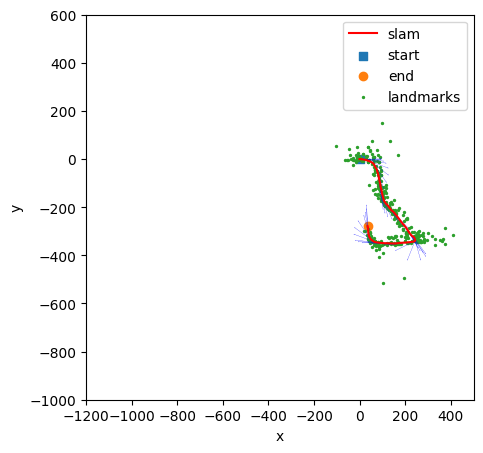

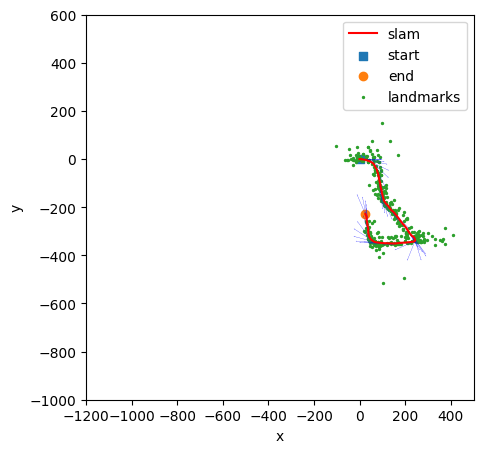

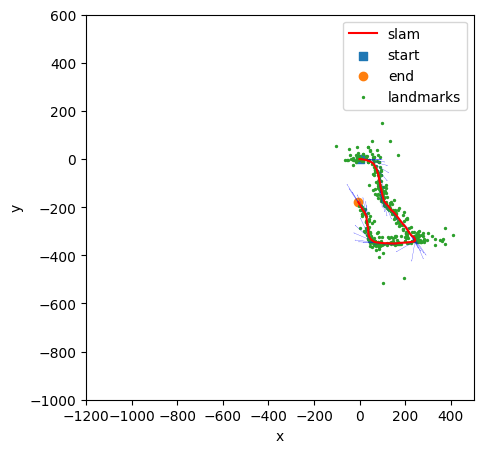

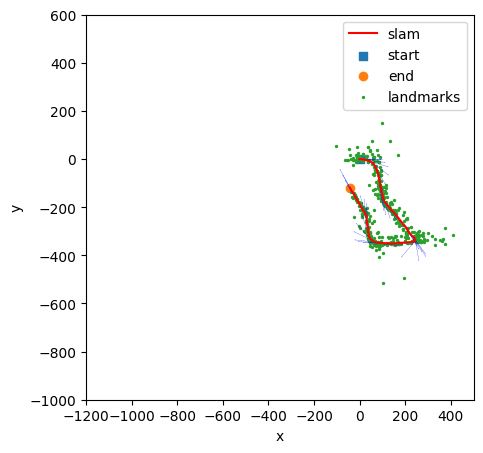

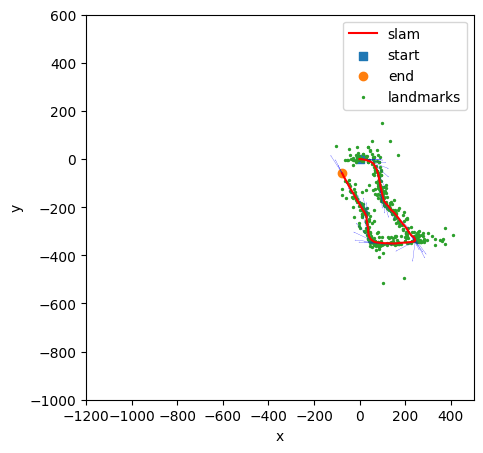

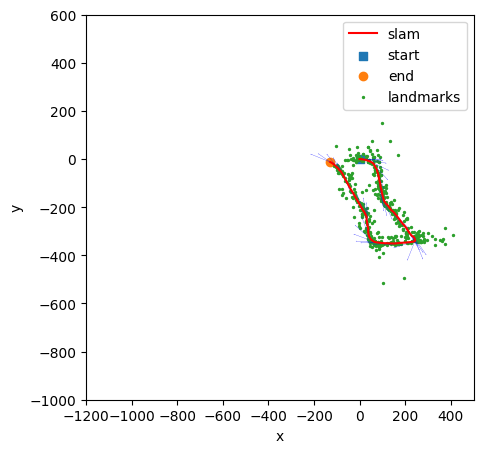

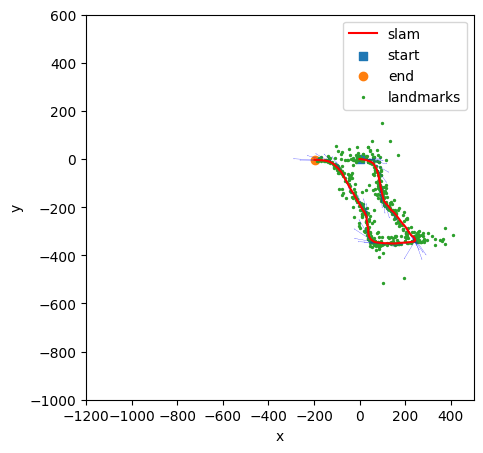

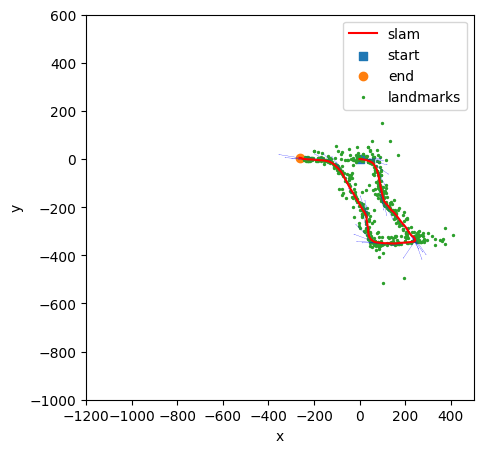

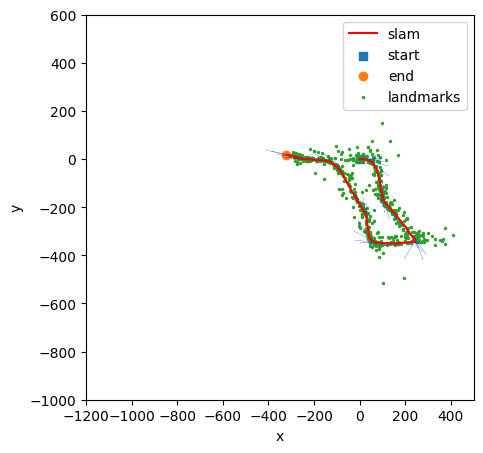

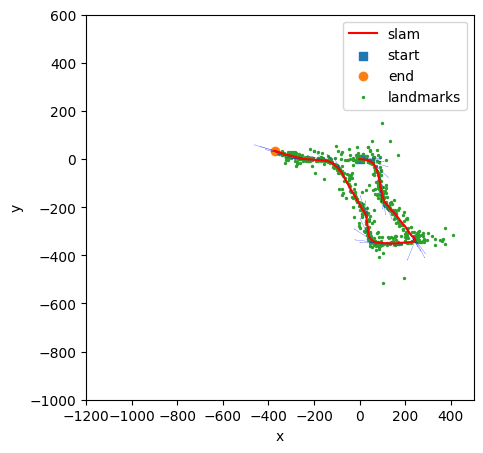

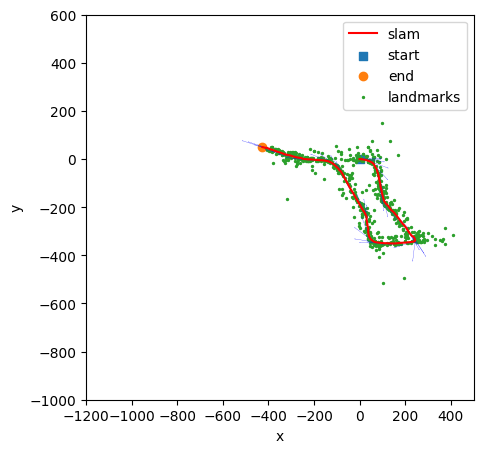

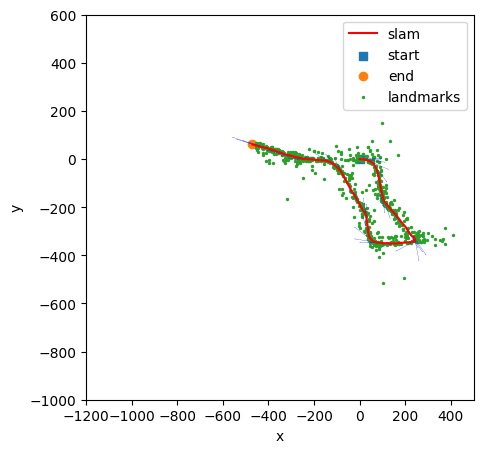

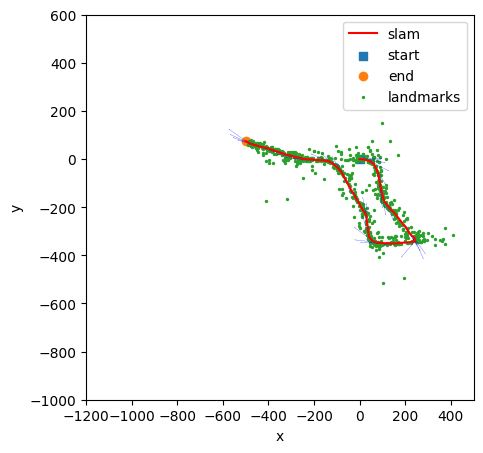

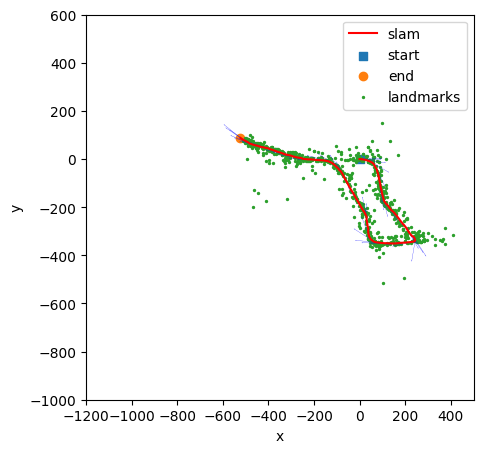

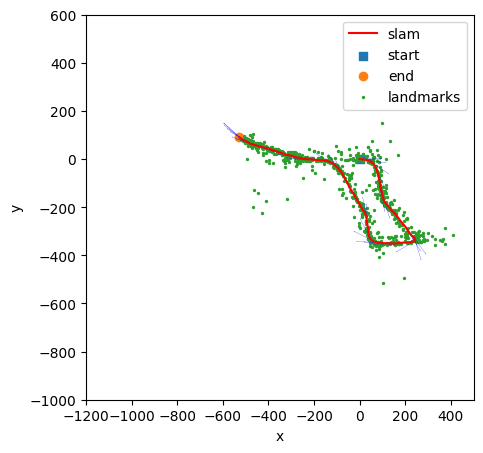

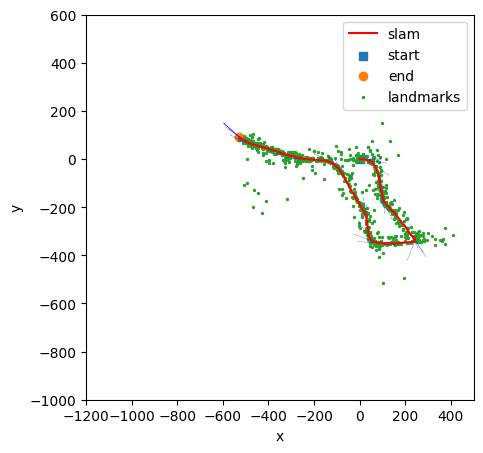

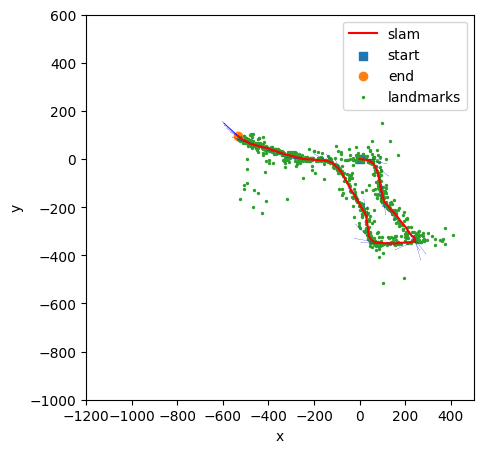

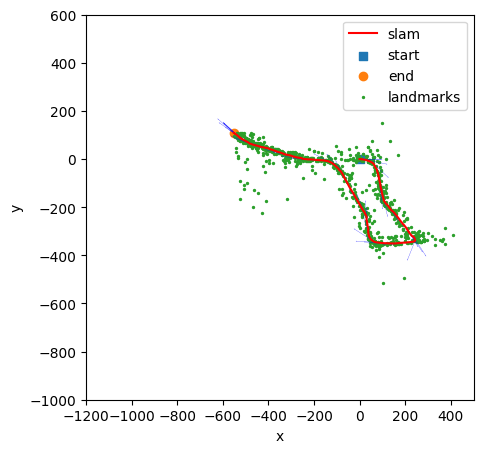

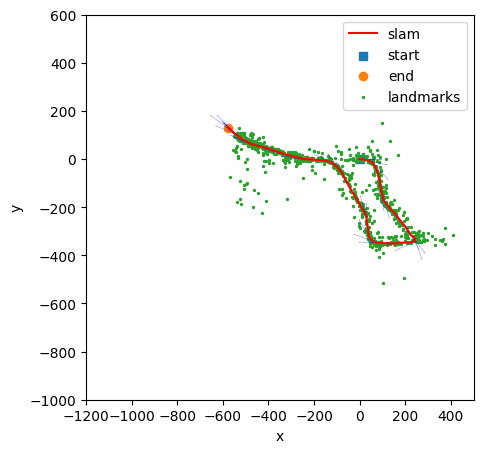

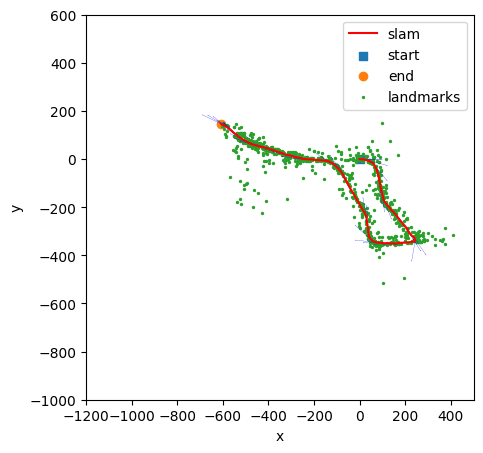

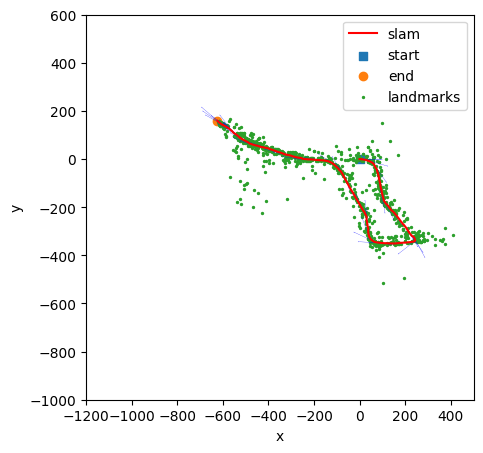

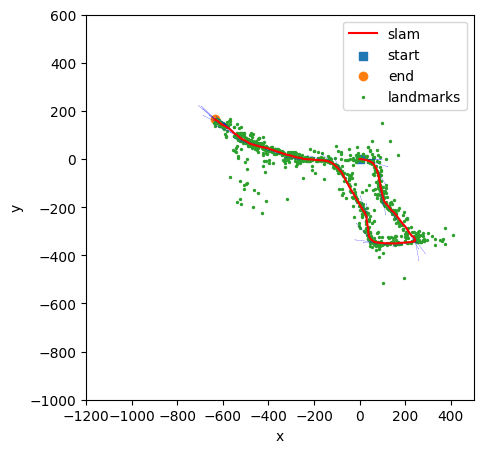

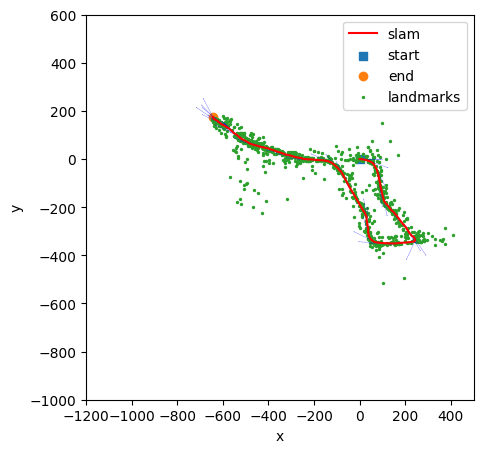

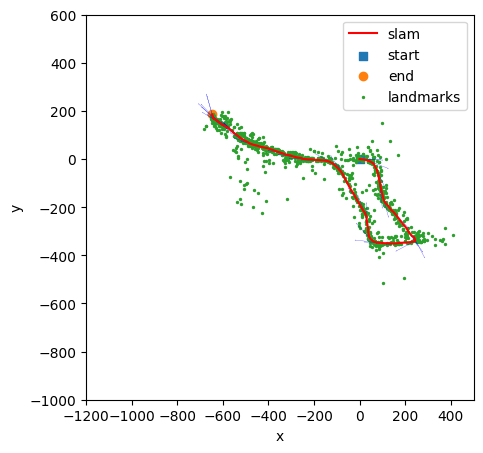

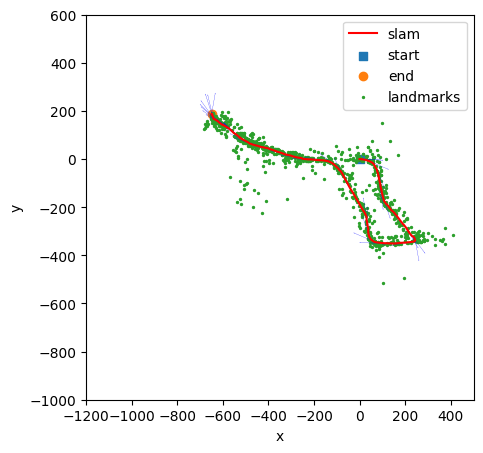

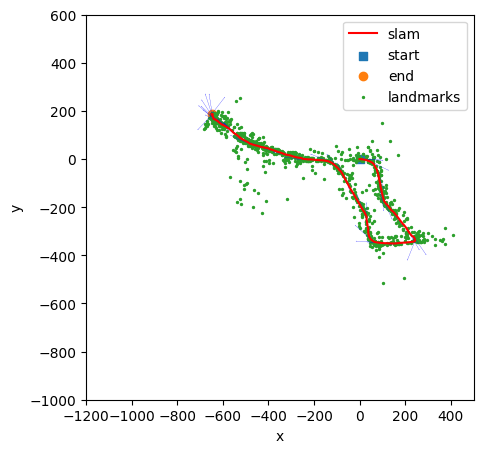

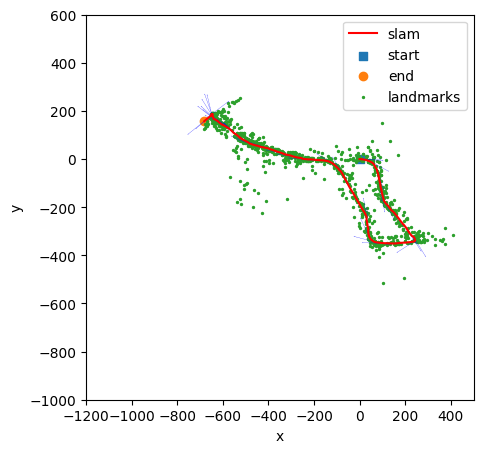

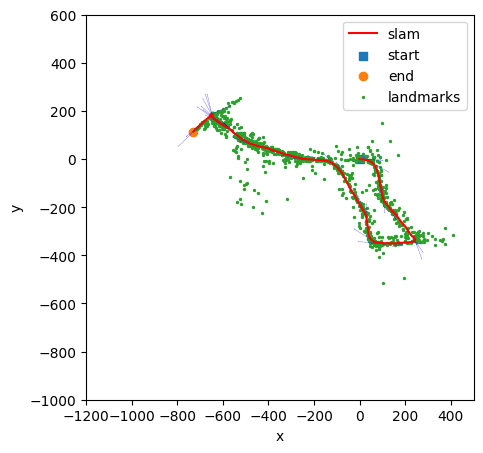

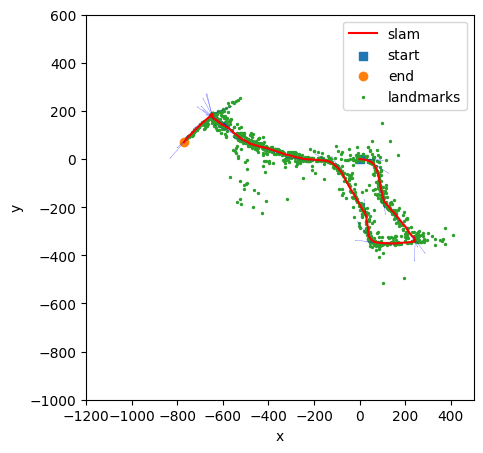

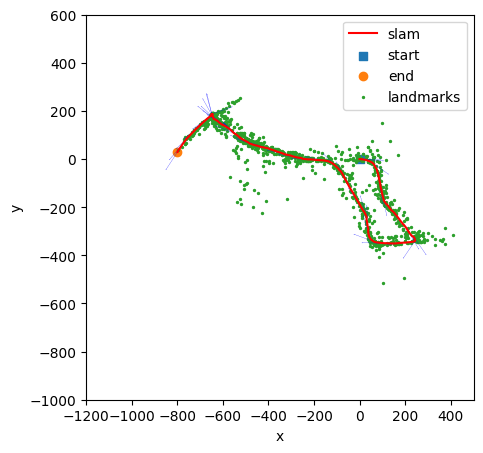

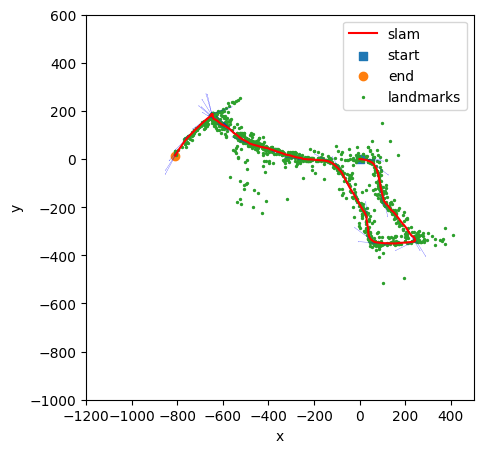

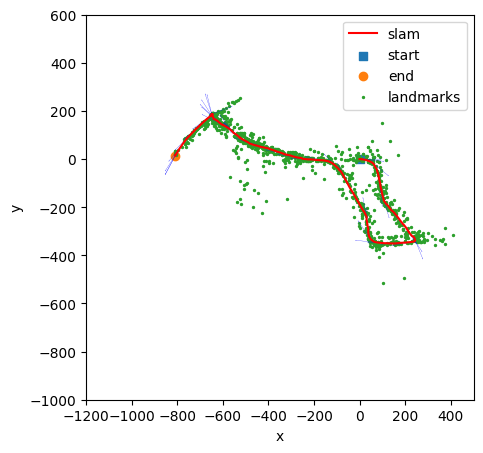

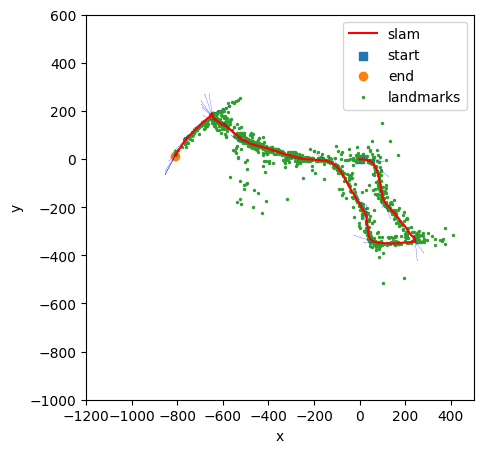

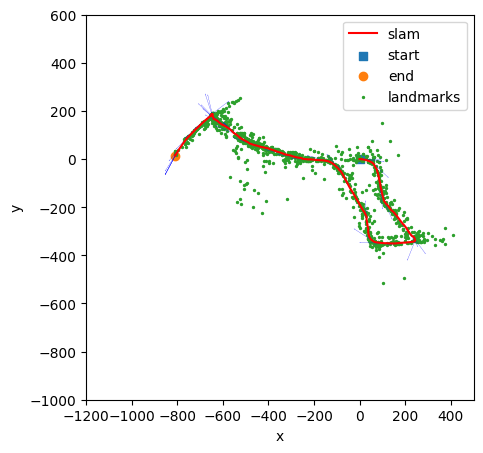

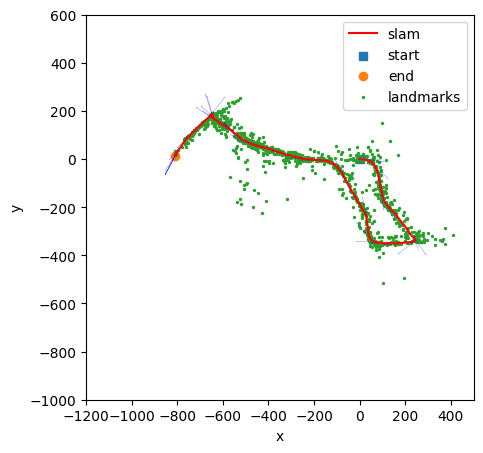

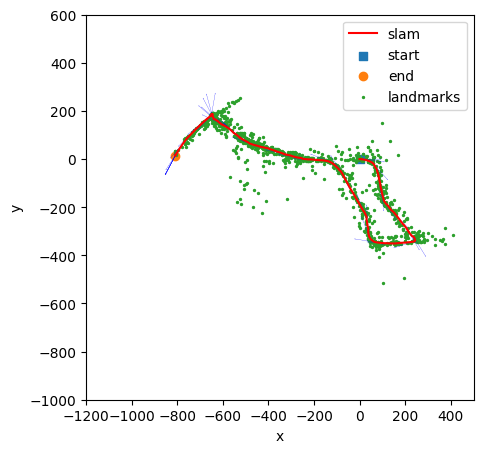

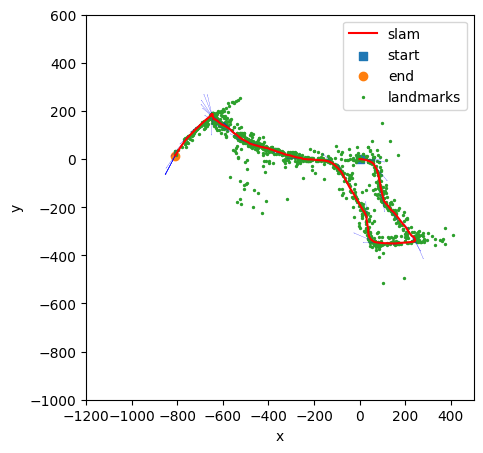

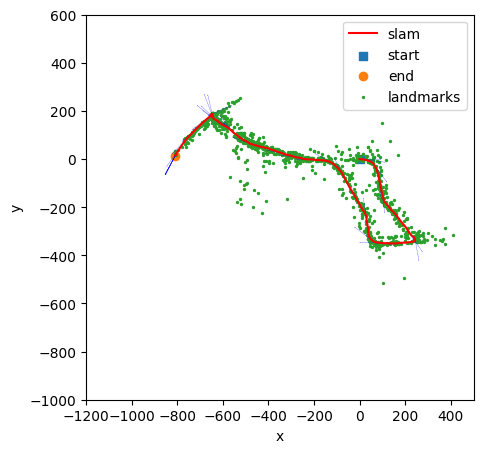

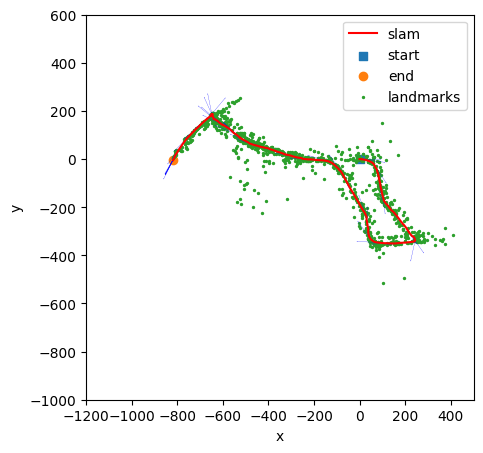

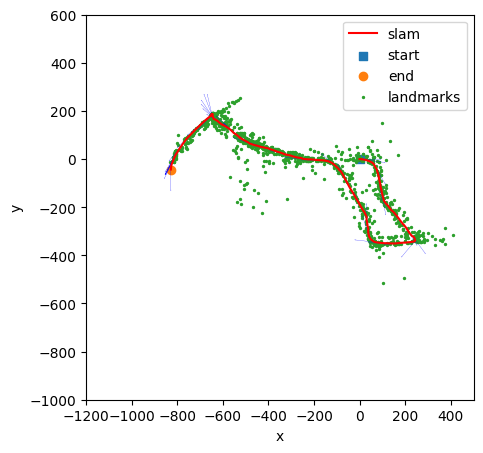

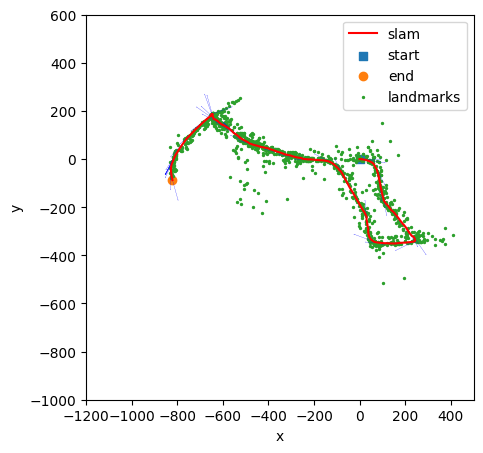

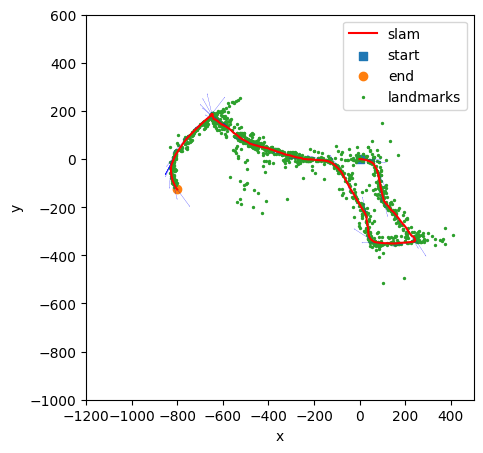

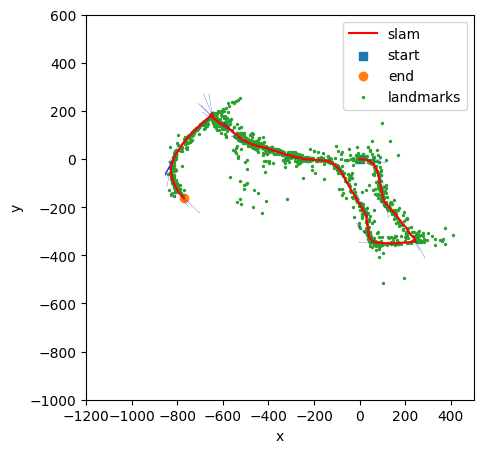

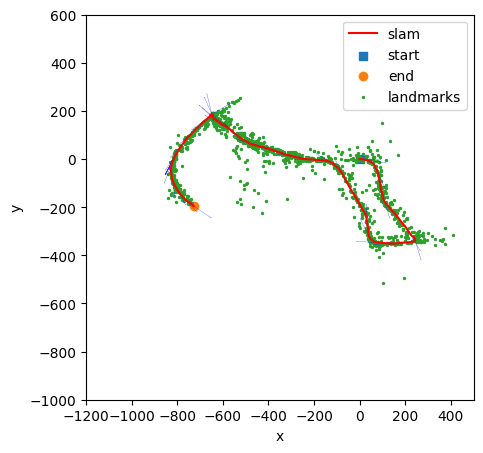

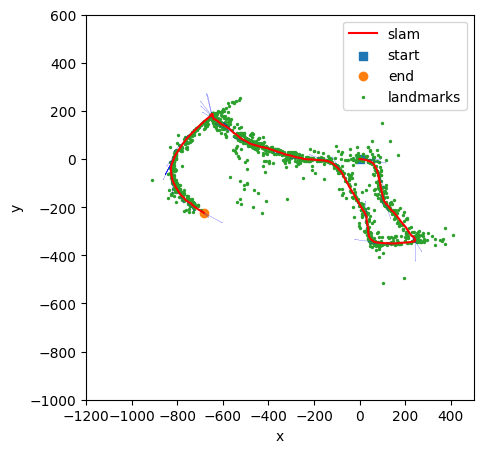

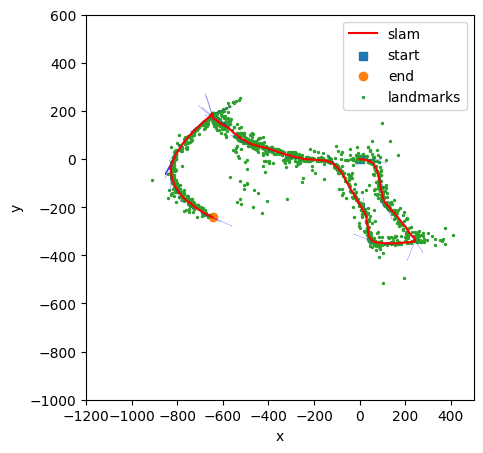

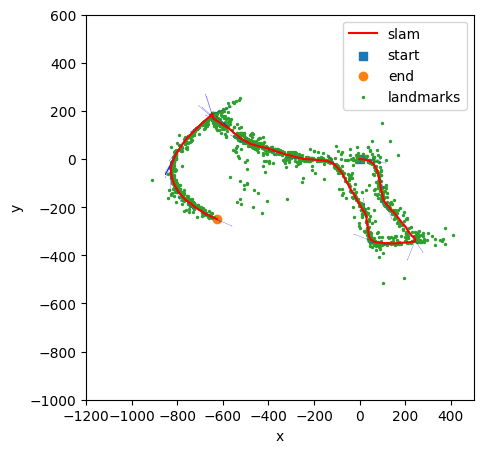

In [8]:
# (c) Visual-Inertial SLAM
print("Start Visual-Inertial SLAM ...")
slam_iTw, slam_wTi, slam_landmarks = visual_slam(t, linear_velocity, angular_velocity, selected_feats, K, b, cam_T_imu, dataset, reduce_factor, v_scale, w_scale)
visualize(slam_wTi, slam_landmarks, save_path_slam)

In [9]:
def combine_visualize_t(pose,slam_pose, landmarks, slam_landmarks, save_path, path_name="Unknown", show_ori=True, show_plot=False):
    fig,ax = plt.subplots(figsize=(5,5))
    n_pose = pose.shape[2]

    ax.plot(pose[0,3,:], pose[1,3,:], 'b-', label='orig')
    ax.plot(slam_pose[0,3,:], slam_pose[1,3,:],'r-',label='slam')
    ax.scatter(pose[0,3,0], pose[1,3,0], marker='s', label="start")
    ax.scatter(pose[0,3,-1], pose[1,3,-1], marker='o', label="end")
    ax.scatter(slam_landmarks[:,0], slam_landmarks[:,1], s=2, marker='o', label="slam_landmarks")
    ax.scatter(landmarks[:,0], landmarks[:,1], s=2, marker='o', label="landmarks")
    
    
    if show_ori:
        select_ori_index = list(range(0,n_pose,int(n_pose/50)))
        yaw_list = []
        for i in select_ori_index:
            _,_,yaw = mat2euler(pose[:3,:3,i])
            yaw_list.append(yaw)
        dx = np.cos(yaw_list)
        dy = np.sin(yaw_list)
        dx,dy = [dx,dy ] /np.sqrt(dx ** 2 + dy ** 2)
        ax.quiver(pose[0, 3, select_ori_index], pose[1, 3, select_ori_index], dx, dy,\
            color="b", units="xy", width=1)
        
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.grid(False)
    ax.legend()

    ax.set_aspect('auto')
    ax.set_xlim([-1200, 500])
    ax.set_ylim([-1000, 600])
    # ax.set_xlim([-1000, 300])
    # ax.set_ylim([-500, 700])

    plt.savefig(save_path, dpi=150)

    if show_plot:
        plt.show(block=True)
    # plt.close()
    return fig, ax

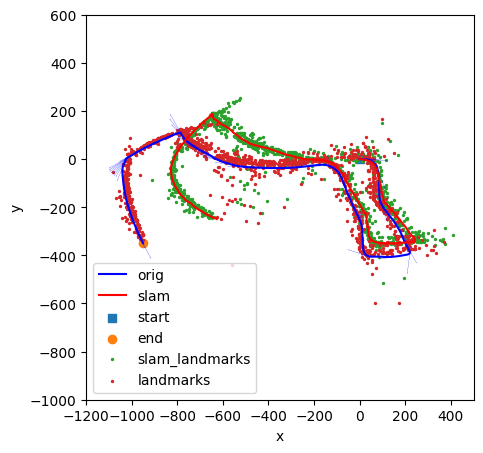

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [10]:
# You can use the function below to visualize the robot pose over time
# visualize_trajectory_2d(world_T_imu, show_ori = True)
# compare result of dead-reckoning and visual slam
# combine_visualize(w_T_i, slam_wTi, landmarks, slam_landmarks, save_path_compare, show_plot=True)
combine_visualize_t(w_T_i, slam_wTi, landmarks, slam_landmarks, save_path_compare, show_plot=True)

In [29]:
import glob
from PIL import Image

def GetGif(frame_folder, save_path):
    fn = glob.glob(f"{frame_folder}/slam_10*.png")
    fn_for = sorted(fn, key=lambda x: int(x.split("_")[-1].split(".")[0]))
    fn_rev = sorted(fn, key=lambda x: int(x.split("_")[-1].split(".")[0]), reverse=True)
    frames = [Image.open(image) for image in fn_for] + [Image.open(fn_for[-1])]*2 + [Image.open(image) for image in fn_rev]
    # frames = [Image.open(image) for image in fn_for]
    frame_one = frames[0]
    frame_one.save(save_path, format="GIF", append_images=frames,
                save_all=True, duration=50, loop=0)
    

In [30]:
frame_folder = "../frames/"
GetGif(frame_folder, "slam10.gif")